# 0. Getting Data

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Import scripts 
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Foodvision Mini model

## 1.1 Getting data

The dataset we're going to use for deploying a FoodVision Mini model (food classification model) is a sample of pizza, steak and sushi images from the Food101 dataset (101 food classes with 1,000 images each). 
More specifically, for our purposes we use 20% of images from the pizza, steak and sushi classes selected at random.

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/vic-art/Food-classification-model-and-deployment/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 1.2 FoodVision Mini model deployment outline

### Before the deployment we have to respond to the following 3 questions:
1. What is the most ideal machine learning model development scenario?
2. Where is the model going to go?
3. How is the model going to function?

**FoodVision Mini ideal use case** A model that performs well and fast. 

1. Performs well: 95%+ accuracy. 
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
  * Latency - time for prediction to take place

To try and achive these goals, we're going to build 2 model experiments:
1. EffNetB2 feature extractor
2. ViT feature extractor


## 1.3 Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output or head layers customized to a certain problem.

In [6]:
# 1.  Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2.  Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

# 4. Freeze the base layers in the model, this will stop all layers from training
for param in effnetb2.parameters():
  param.requires_grad = False


In [7]:
from torchinfo import summary


summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3, # change out_features to suit our problem (3)
              bias=True)
)

### 1.3.1 Creating a function to make an EffNetB2 feature extractor

We can create a function to make an EffNetB2 feature extractor. This function takes a customizable number of classes and a random seed parameter for reproducibility.

In [10]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
  """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # 4. Freeze the base layers in the model, this will stop all layers from training
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed 
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, transforms


In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3, 
                                                      seed  = 42)

In [12]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
from torchinfo import summary

summary(effnetb2, 
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

### 1.3.2 Creating DataLoaders for EffNetB2

We can create DataLoaders using `data_setup.create_dataloaders()` function.
We use a `batch_size` of 32 images and transform images using `effnetb2_transforms` so they're in the same format as the images our effnetb2 model was trained on.

In [14]:
from scripts import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir, 
                                                                                                 test_dir = test_dir,
                                                                                                 transform = effnetb2_transforms,
                                                                                                 batch_size = 32)


In [15]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 1.3.3 Training EffNetB2 feature extractor

We train EffNetB2 feature extractor model for 10 epochs using `engine.train()` function with `torch.optim.Adam()` and a learning rate of 1e-3 as our optimizer and `torch.nn.CrossEntropyLoss()` as our loss function.

In [16]:
from torch.optim import optimizer
from scripts import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(), 
                             lr = 1e-3)

# Training function
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                loss_fn = loss_fn,
                                optimizer = optimizer,
                                device = device)


 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Epoch: 1 | train_loss: 0.9843 | train_acc: 0.5667 | test_loss: 0.7410 | test_acc: 0.9347


 20%|██        | 2/10 [00:04<00:18,  2.31s/it]

Epoch: 2 | train_loss: 0.7171 | train_acc: 0.8396 | test_loss: 0.5877 | test_acc: 0.9409


 30%|███       | 3/10 [00:06<00:15,  2.22s/it]

Epoch: 3 | train_loss: 0.5878 | train_acc: 0.8938 | test_loss: 0.4901 | test_acc: 0.9563


 40%|████      | 4/10 [00:08<00:12,  2.17s/it]

Epoch: 4 | train_loss: 0.4481 | train_acc: 0.9125 | test_loss: 0.4349 | test_acc: 0.9409


 50%|█████     | 5/10 [00:10<00:10,  2.14s/it]

Epoch: 5 | train_loss: 0.4302 | train_acc: 0.9062 | test_loss: 0.3921 | test_acc: 0.9443


 60%|██████    | 6/10 [00:13<00:08,  2.11s/it]

Epoch: 6 | train_loss: 0.4399 | train_acc: 0.8875 | test_loss: 0.3523 | test_acc: 0.9597


 70%|███████   | 7/10 [00:15<00:06,  2.12s/it]

Epoch: 7 | train_loss: 0.4254 | train_acc: 0.8792 | test_loss: 0.3267 | test_acc: 0.9563


 80%|████████  | 8/10 [00:17<00:04,  2.12s/it]

Epoch: 8 | train_loss: 0.3900 | train_acc: 0.8979 | test_loss: 0.3462 | test_acc: 0.9443


 90%|█████████ | 9/10 [00:19<00:02,  2.13s/it]

Epoch: 9 | train_loss: 0.3769 | train_acc: 0.8771 | test_loss: 0.3130 | test_acc: 0.9131


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]

Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8625 | test_loss: 0.2814 | test_acc: 0.9688


### 1.3.4 Inspecting EffNetB2 Loss curves

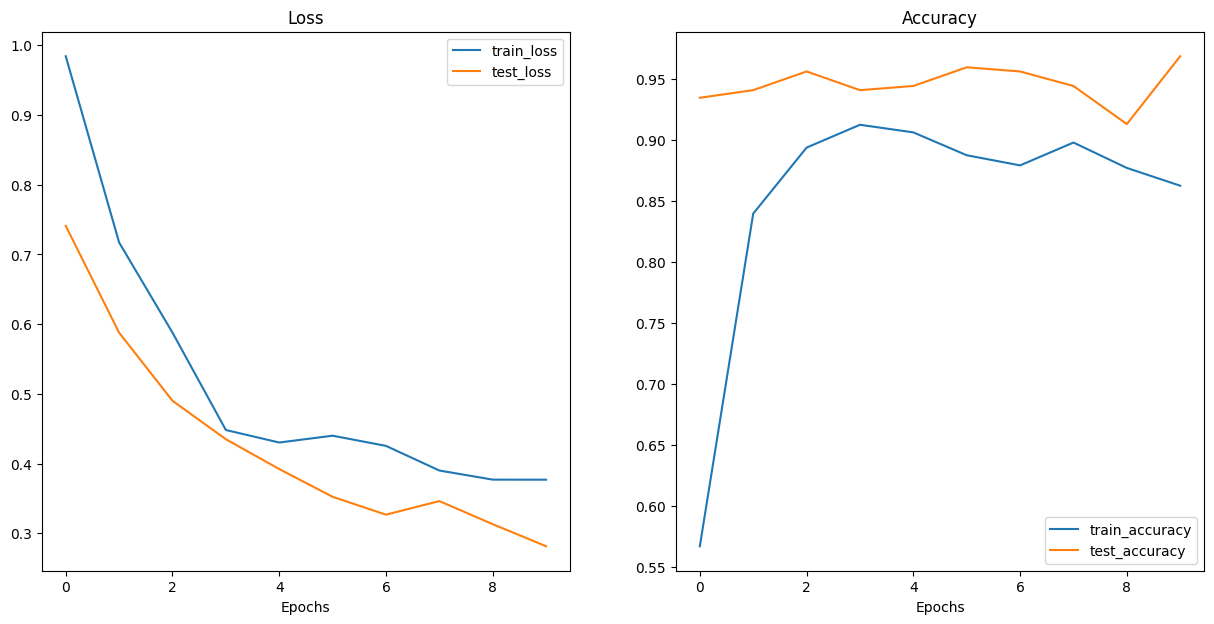

In [17]:
from scripts.helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

It looks like the model is performing quite well and perhaps could benefit from a little longer training. 

We can use the save_model() function for saving the model to the file so we can import and use it later.

### 1.3.5 Saving EffNetB2 feature extractor

In [18]:
from scripts.helper_functions import save_model

# Save the model
save_model(model = effnetb2, 
          target_dir = "models",
          model_name = "pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth


### 1.3.6 Inspecting the size of EffNet feature extractor

If we are deploying our model on a mobile device/website, there may be limited compute resourses, that's why we need to check the model's size.

So if the model is too large, we may not be able to store/run it on the target device. 

In [19]:
from pathlib import Path

# Get the model size in bytes

pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB2 model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 model size: 29 MB


### 1.3.7 Collecting EffNetB2 feature extractor stats

We can count the number of weights in effnetb2.parameters() using torch.numel() method.

In [20]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

In [21]:
effnetb2_total_params

7705221

We create a dictionary to store main EffNetB2's statistics, including test loss, test accuracy, model size and number of parameters in order to compare them with the corresponding statistics of the upcoming ViT feature extractor.

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28141466379165647,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

Our model performs with over 95% accuracy. The first criterion is met. 

## 1.4 Create a ViT feature extractor

We'll start by creating a function called `create_vit_model()` which will be very similar to `create_effnetb2_model()`. 

In [23]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [25]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [26]:
from torchinfo import summary

# Print ViT feature extractor model summary 
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 1.4.1 Create DataLoaders for ViT

In [27]:
# Setup ViT DataLoaders
from scripts import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### 1.4.2 Training ViT feature extractor

We train ViT feature extractor model for 10 epochs using `engine.train()` function with `torch.optim.Adam()` and a learning rate of 1e-3 as our optimizer and `torch.nn.CrossEntropyLoss()` as our loss function.

In [28]:
from scripts import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

 10%|█         | 1/10 [00:03<00:28,  3.12s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [00:05<00:23,  2.96s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [00:17<00:11,  2.84s/it]

Epoch: 6 | train_loss: 0.1273 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [00:20<00:08,  2.84s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 1.4.3 Inspecting ViT loss curves

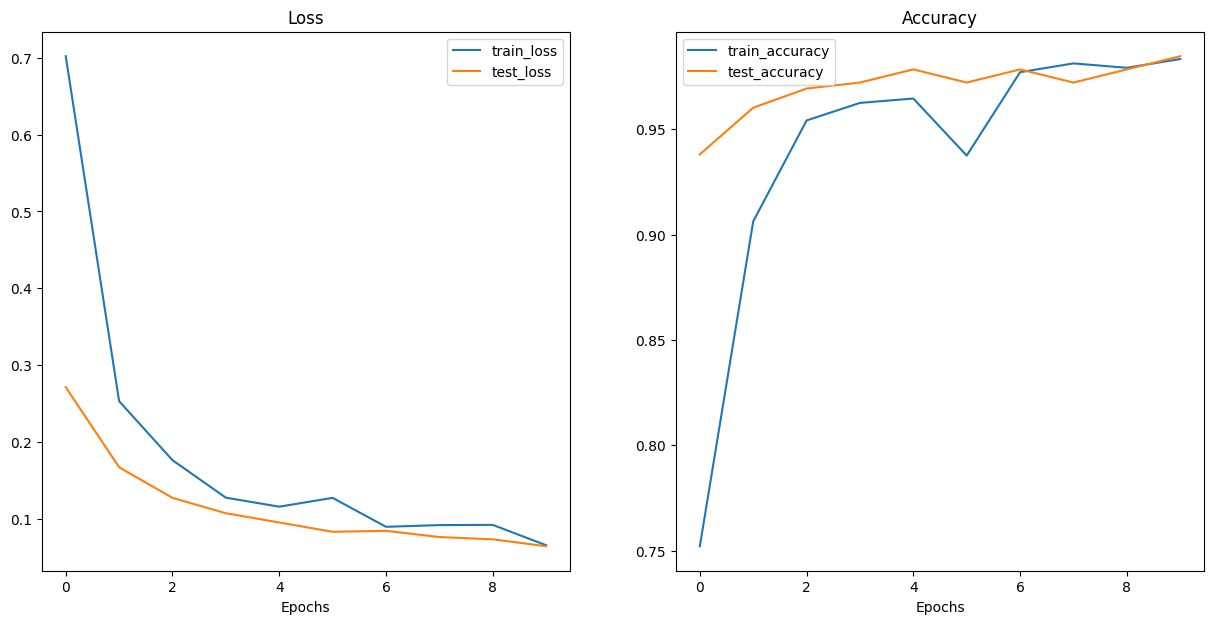

In [29]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

Just like in the EffNetB2 feature extractor model results plot, we can see the desired loss and accuracy behavior, the ViT model can also benefit from a slightly longer training time.

### 1.4.4 Saving ViT feature extractor

In [30]:
# Save the model
from scripts.helper_functions import save_model

save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 1.4.5 Checking the size of ViT feature extractor

Since we want to compare our EffNetB2 model to our ViT model across a number of characteristics, let's find out its size.

In [31]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 1.4.6 Collecting ViT feature extractor stats

In [32]:
# Count number of parameters in ViT 
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [33]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06444406174123288,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [34]:
effnetb2_stats

{'test_loss': 0.28141466379165647,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 1.5 Making predictions with our trained models and timing them

Our goals are:
1. Performs well (95% test accuracy)
2. Fast (30+FPS)

As we can see, both models meet test criteria 2 of over 95% performance on the test set.

To test criteria 2 we need to:
1. Loop through test images
2. Calculate how long it takes each model to make a prediction on the image.

First, we'll need a list of test image paths. We use Python's `pathlib.Path("target_dir").glob("*/*.jpg"))` to find all of the filepaths in a target directory with the extension .jpg.

We time the predictions one by one rather than by batch because when our model is deployed, it will likely only be making a prediction on one image at a time. As in, someone takes a photo and our model predicts on that single image.

In [35]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg')]

### 1.5.1 Creating a function to make predictions across the test dataset

Steps to create `pred_and_store()`:
1. Create a funciton that takes a list of paths and a trained PyTorch model and a series of transforms, a list of target class names and target device. 
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths.
4. Create an empty dictionary for each sample (prediction statistics will go here).
5. Get the sample path and ground truth class from the filepath. 
6. Start the prediction timer.
7. Open image with `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode. 
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate the pred probs + pred class. 
11. Add pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary. 
13. See if the predicited class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2. 
15. Return the list of prediction dictionaries. 




In [36]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1.  Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module, 
                   transforms: torchvision.transforms, 
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires.
    pred_list = []

    # 3. Loop through the target input paths.
    for path in tqdm(paths):
      
      # 4. Create empty dictionary to store prediction information for each sample.
      pred_dict = {}

      # 5. Get the sample path and ground truth class name.
      pred_dict["image_path"] = path
      class_name = path.parent.stem
      pred_dict["class_name"] = class_name

      # 6. Start the prediction timer.
      start_time = timer()

      # 7. Open image with Image.open(path).
      img = Image.open(path)

      # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device).
      transformed_image = transforms(img).unsqueeze(0).to(device)

      # 9. Prepare the model for inference by sending it to the target device and turning on eval() mode.
      model = model.to(device)
      model.eval()

      # 10. Turn on torch.inference_mode(), pass the target transformed image to the model, get prediction probability, predicition label and prediction class 
      with torch.inference_mode():
        pred_logit = model(transformed_image) # perform inference on target sample
        pred_prob = torch.softmax(pred_logit, dim =1)  # turn logits into prediction probabilities
        print(pred_prob)
        pred_label = torch.argmax(pred_prob, dim = 1) # turn prediction probabilities into prediction label
        pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU 

        # 11. Add pred prob + pred class to empty dictionary from step 4. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class

        # 12. End the timer and calculate time per pred 
        end_time = timer()
        pred_dict["time_for_pred"] = round(end_time - start_time, 4)
      
      # 13. See if the predicited class matches the ground truth class.
      pred_dict["correct"] = class_name == pred_class

      # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
      pred_list.append(pred_dict)
    
    # Return the list of prediction dictionaries.
    return pred_list

### 1.5.2 Making and timing predictions with EffNetB2

Let's use the function `pred_and_store()` to make predictions across the test dataset with our EffNetB2 model.

2 thing to note:
1. Device - we hardcode predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy the model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`). 

In [37]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(
    paths = test_data_paths, 
    model = effnetb2, 
    transforms = effnetb2_transforms, 
    class_names = class_names, 
    device = "cpu" # hardcode predictions to happen on CPU
)

  3%|▎         | 4/150 [00:00<00:08, 16.24it/s]

tensor([[0.4239, 0.1905, 0.3856]])
tensor([[0.7420, 0.1124, 0.1456]])
tensor([[0.9187, 0.0350, 0.0463]])
tensor([[0.8503, 0.1191, 0.0306]])
tensor([[0.7983, 0.0875, 0.1141]])


  7%|▋         | 10/150 [00:00<00:06, 20.41it/s]

tensor([[0.8104, 0.0945, 0.0951]])
tensor([[0.8207, 0.1006, 0.0787]])
tensor([[0.9272, 0.0312, 0.0417]])
tensor([[0.9850, 0.0064, 0.0086]])
tensor([[0.3187, 0.3712, 0.3101]])


  9%|▊         | 13/150 [00:00<00:06, 21.08it/s]

tensor([[0.6960, 0.1558, 0.1481]])
tensor([[0.9874, 0.0074, 0.0052]])
tensor([[0.9184, 0.0461, 0.0355]])
tensor([[0.7908, 0.0413, 0.1679]])
tensor([[0.8574, 0.0365, 0.1061]])


 13%|█▎        | 19/150 [00:00<00:05, 21.86it/s]

tensor([[0.5586, 0.0919, 0.3496]])
tensor([[0.9346, 0.0109, 0.0545]])
tensor([[0.9468, 0.0246, 0.0286]])
tensor([[0.9423, 0.0199, 0.0378]])
tensor([[0.7121, 0.1390, 0.1489]])


 17%|█▋        | 25/150 [00:01<00:05, 22.29it/s]

tensor([[0.9921, 0.0049, 0.0031]])
tensor([[0.9139, 0.0248, 0.0613]])
tensor([[0.7545, 0.1763, 0.0691]])
tensor([[0.6227, 0.3094, 0.0680]])
tensor([[0.4828, 0.2307, 0.2864]])


 19%|█▊        | 28/150 [00:01<00:05, 22.24it/s]

tensor([[0.7495, 0.0223, 0.2282]])
tensor([[0.8129, 0.0375, 0.1497]])
tensor([[0.9560, 0.0367, 0.0073]])
tensor([[0.6497, 0.2085, 0.1418]])
tensor([[0.7656, 0.1374, 0.0970]])


 23%|██▎       | 34/150 [00:01<00:05, 22.42it/s]

tensor([[0.9704, 0.0162, 0.0134]])
tensor([[0.9579, 0.0177, 0.0244]])
tensor([[0.8828, 0.0232, 0.0941]])
tensor([[0.7122, 0.1857, 0.1021]])
tensor([[0.6342, 0.1870, 0.1788]])


 27%|██▋       | 40/150 [00:01<00:04, 22.23it/s]

tensor([[0.9222, 0.0558, 0.0220]])
tensor([[0.8627, 0.0986, 0.0386]])
tensor([[0.9812, 0.0100, 0.0088]])
tensor([[0.4097, 0.0715, 0.5188]])
tensor([[0.6508, 0.1021, 0.2471]])


 29%|██▊       | 43/150 [00:02<00:04, 22.13it/s]

tensor([[0.9824, 0.0083, 0.0093]])
tensor([[0.5551, 0.0704, 0.3745]])
tensor([[0.9939, 0.0030, 0.0031]])
tensor([[0.9463, 0.0285, 0.0252]])
tensor([[0.9739, 0.0141, 0.0119]])


 33%|███▎      | 49/150 [00:02<00:04, 22.42it/s]

tensor([[0.9562, 0.0211, 0.0227]])
tensor([[0.3247, 0.2142, 0.4611]])
tensor([[0.0114, 0.0337, 0.9549]])
tensor([[0.0895, 0.4032, 0.5072]])
tensor([[0.0610, 0.0332, 0.9059]])


 37%|███▋      | 55/150 [00:02<00:04, 22.60it/s]

tensor([[0.0095, 0.0295, 0.9611]])
tensor([[0.1774, 0.0984, 0.7242]])
tensor([[0.2274, 0.0498, 0.7229]])
tensor([[0.1821, 0.0723, 0.7457]])
tensor([[0.0340, 0.3935, 0.5725]])


 39%|███▊      | 58/150 [00:02<00:04, 22.48it/s]

tensor([[0.0381, 0.1795, 0.7824]])
tensor([[0.0359, 0.0125, 0.9516]])
tensor([[0.0570, 0.0669, 0.8761]])
tensor([[0.0361, 0.0970, 0.8669]])
tensor([[0.0080, 0.0394, 0.9526]])


 43%|████▎     | 64/150 [00:02<00:03, 22.49it/s]

tensor([[0.0577, 0.2632, 0.6791]])
tensor([[0.1742, 0.2425, 0.5833]])
tensor([[0.2065, 0.1736, 0.6199]])
tensor([[0.0345, 0.0183, 0.9472]])
tensor([[0.0403, 0.0790, 0.8807]])


 47%|████▋     | 70/150 [00:03<00:03, 22.46it/s]

tensor([[0.0637, 0.1070, 0.8293]])
tensor([[0.0301, 0.0557, 0.9142]])
tensor([[0.0465, 0.0409, 0.9125]])
tensor([[0.0249, 0.0923, 0.8828]])
tensor([[0.0838, 0.4029, 0.5133]])


 49%|████▊     | 73/150 [00:03<00:03, 22.40it/s]

tensor([[0.1404, 0.0579, 0.8018]])
tensor([[0.1180, 0.1132, 0.7688]])
tensor([[0.1292, 0.1101, 0.7607]])
tensor([[0.0214, 0.0254, 0.9533]])
tensor([[0.1217, 0.0927, 0.7856]])


 53%|█████▎    | 79/150 [00:03<00:03, 22.37it/s]

tensor([[0.1953, 0.2404, 0.5643]])
tensor([[0.0517, 0.0345, 0.9138]])
tensor([[0.0972, 0.0745, 0.8282]])
tensor([[0.0642, 0.3965, 0.5393]])
tensor([[0.2535, 0.1269, 0.6197]])


 57%|█████▋    | 85/150 [00:03<00:02, 22.32it/s]

tensor([[0.1827, 0.2127, 0.6045]])
tensor([[0.0550, 0.2799, 0.6651]])
tensor([[0.0543, 0.6421, 0.3036]])
tensor([[0.0260, 0.1088, 0.8652]])
tensor([[0.0536, 0.0299, 0.9165]])


 59%|█████▊    | 88/150 [00:04<00:02, 22.27it/s]

tensor([[0.0502, 0.0796, 0.8702]])
tensor([[0.1064, 0.0575, 0.8360]])
tensor([[0.1124, 0.0480, 0.8396]])
tensor([[0.0269, 0.0438, 0.9293]])
tensor([[0.0944, 0.0624, 0.8433]])


 63%|██████▎   | 94/150 [00:04<00:02, 22.35it/s]

tensor([[0.1652, 0.2311, 0.6037]])
tensor([[0.1351, 0.3789, 0.4860]])
tensor([[0.1460, 0.7485, 0.1056]])
tensor([[0.2623, 0.6156, 0.1220]])
tensor([[0.1337, 0.7849, 0.0814]])


 67%|██████▋   | 100/150 [00:04<00:02, 22.25it/s]

tensor([[0.0469, 0.7160, 0.2370]])
tensor([[0.1938, 0.7843, 0.0219]])
tensor([[0.0252, 0.9070, 0.0678]])
tensor([[0.0063, 0.9862, 0.0075]])
tensor([[0.0328, 0.8534, 0.1138]])


 69%|██████▊   | 103/150 [00:04<00:02, 21.73it/s]

tensor([[0.2997, 0.4084, 0.2919]])
tensor([[0.1233, 0.5927, 0.2840]])
tensor([[0.1147, 0.7505, 0.1348]])
tensor([[0.0980, 0.8912, 0.0108]])
tensor([[0.0602, 0.9210, 0.0188]])


 73%|███████▎  | 109/150 [00:04<00:01, 21.61it/s]

tensor([[0.1292, 0.6642, 0.2067]])
tensor([[0.0453, 0.8947, 0.0599]])
tensor([[0.0386, 0.9329, 0.0286]])
tensor([[0.1130, 0.8474, 0.0396]])
tensor([[0.1157, 0.8487, 0.0356]])


 77%|███████▋  | 115/150 [00:05<00:01, 21.97it/s]

tensor([[0.1894, 0.7324, 0.0782]])
tensor([[0.0435, 0.8863, 0.0703]])
tensor([[0.0390, 0.9232, 0.0378]])
tensor([[0.0044, 0.9342, 0.0615]])
tensor([[0.0178, 0.9570, 0.0252]])


 79%|███████▊  | 118/150 [00:05<00:01, 22.05it/s]

tensor([[0.1426, 0.4608, 0.3966]])
tensor([[0.0055, 0.9326, 0.0619]])
tensor([[0.0545, 0.9246, 0.0209]])
tensor([[0.0186, 0.7937, 0.1877]])
tensor([[0.0403, 0.9269, 0.0328]])


 83%|████████▎ | 124/150 [00:05<00:01, 22.18it/s]

tensor([[0.0073, 0.9423, 0.0504]])
tensor([[0.0396, 0.8013, 0.1592]])
tensor([[0.0157, 0.8700, 0.1144]])
tensor([[0.1369, 0.6623, 0.2008]])
tensor([[0.0985, 0.7995, 0.1020]])


 87%|████████▋ | 130/150 [00:05<00:00, 22.22it/s]

tensor([[0.0513, 0.8693, 0.0794]])
tensor([[0.0852, 0.4871, 0.4277]])
tensor([[0.0394, 0.9283, 0.0323]])
tensor([[0.1864, 0.7872, 0.0264]])
tensor([[0.0375, 0.6670, 0.2955]])


 89%|████████▊ | 133/150 [00:06<00:00, 22.07it/s]

tensor([[0.0495, 0.9291, 0.0214]])
tensor([[0.0353, 0.9482, 0.0164]])
tensor([[0.2009, 0.7677, 0.0314]])
tensor([[0.1959, 0.7245, 0.0797]])
tensor([[0.0317, 0.7757, 0.1926]])


 93%|█████████▎| 139/150 [00:06<00:00, 22.13it/s]

tensor([[0.0757, 0.8322, 0.0922]])
tensor([[0.2343, 0.2378, 0.5279]])
tensor([[0.2341, 0.3843, 0.3816]])
tensor([[0.0136, 0.9457, 0.0407]])
tensor([[0.0440, 0.9465, 0.0095]])


 97%|█████████▋| 145/150 [00:06<00:00, 22.23it/s]

tensor([[0.0450, 0.6848, 0.2702]])
tensor([[0.2286, 0.6296, 0.1417]])
tensor([[0.0592, 0.8602, 0.0806]])
tensor([[0.2007, 0.2105, 0.5888]])
tensor([[0.1509, 0.7351, 0.1140]])


100%|██████████| 150/150 [00:06<00:00, 21.95it/s]

tensor([[0.0379, 0.9216, 0.0405]])
tensor([[0.0741, 0.6212, 0.3047]])
tensor([[0.0393, 0.9208, 0.0399]])
tensor([[0.0041, 0.9893, 0.0066]])
tensor([[0.2371, 0.6654, 0.0975]])


In [39]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4239,
  'pred_class': 'pizza',
  'time_for_pred': 0.1367,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.742,
  'pred_class': 'pizza',
  'time_for_pred': 0.0439,
  'correct': True}]

In [40]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head(5)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.4239,pizza,0.1367,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7420,pizza,0.0439,True
2,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9187,pizza,0.0438,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8503,pizza,0.0436,True
4,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.7983,pizza,0.0435,True


In [41]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

We got 5 wrong predictions out of 150 total.

In [42]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds") 

EffNetB2 average time per prediction: 0.0452 seconds


In [43]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28141466379165647,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0452}

> Prediction time will vary (much like training times) depending on the hardware. So, generally, the faster you compute (e.g. CPU or GPU), the faster the predictions will happen.

### 1.5.3 Making and timing predictions with ViT

In [44]:
# Make predictions test dataset with EffNetB2
vit_test_pred_dicts = pred_and_store(
    paths = test_data_paths, 
    model = vit, 
    transforms = vit_transforms, 
    class_names = class_names, 
    device = "cpu" # hardcode predictions to happen on CPU
)

  2%|▏         | 3/150 [00:00<00:17,  8.42it/s]

tensor([[0.9948, 0.0030, 0.0022]])
tensor([[9.9802e-01, 7.7091e-04, 1.2052e-03]])
tensor([[9.9820e-01, 5.1924e-04, 1.2816e-03]])


  3%|▎         | 5/150 [00:00<00:15,  9.61it/s]

tensor([[9.9831e-01, 8.7127e-04, 8.2150e-04]])
tensor([[0.9917, 0.0011, 0.0072]])
tensor([[0.9935, 0.0016, 0.0049]])


  6%|▌         | 9/150 [00:00<00:13, 10.36it/s]

tensor([[9.9854e-01, 6.6157e-04, 8.0005e-04]])
tensor([[0.9974, 0.0011, 0.0014]])
tensor([[9.9880e-01, 4.8827e-04, 7.1265e-04]])


  7%|▋         | 11/150 [00:01<00:13, 10.59it/s]

tensor([[9.9766e-01, 9.1407e-04, 1.4279e-03]])
tensor([[0.9869, 0.0079, 0.0053]])
tensor([[0.9938, 0.0020, 0.0042]])


 10%|█         | 15/150 [00:01<00:12, 10.84it/s]

tensor([[9.9874e-01, 5.4511e-04, 7.0992e-04]])
tensor([[9.9885e-01, 2.1897e-04, 9.2859e-04]])
tensor([[9.9741e-01, 9.9199e-04, 1.6004e-03]])


 11%|█▏        | 17/150 [00:01<00:12, 10.92it/s]

tensor([[9.9679e-01, 4.2795e-04, 2.7843e-03]])
tensor([[9.9843e-01, 5.3515e-04, 1.0313e-03]])
tensor([[9.9834e-01, 5.5015e-04, 1.1113e-03]])


 14%|█▍        | 21/150 [00:02<00:11, 10.99it/s]

tensor([[9.9773e-01, 9.2890e-04, 1.3408e-03]])
tensor([[0.9732, 0.0022, 0.0246]])
tensor([[9.9871e-01, 3.5957e-04, 9.3183e-04]])


 15%|█▌        | 23/150 [00:02<00:11, 11.03it/s]

tensor([[9.9772e-01, 1.3180e-03, 9.5883e-04]])
tensor([[0.9946, 0.0025, 0.0029]])
tensor([[0.9855, 0.0047, 0.0098]])


 18%|█▊        | 27/150 [00:02<00:11, 11.05it/s]

tensor([[0.9957, 0.0013, 0.0030]])
tensor([[9.9700e-01, 9.7720e-04, 2.0244e-03]])
tensor([[9.9862e-01, 8.1328e-04, 5.6830e-04]])


 19%|█▉        | 29/150 [00:02<00:10, 11.08it/s]

tensor([[0.9959, 0.0011, 0.0030]])
tensor([[0.9877, 0.0111, 0.0012]])
tensor([[0.9698, 0.0081, 0.0221]])


 22%|██▏       | 33/150 [00:03<00:10, 11.10it/s]

tensor([[0.9977, 0.0010, 0.0013]])
tensor([[9.9810e-01, 7.8004e-04, 1.1174e-03]])
tensor([[9.9823e-01, 9.4213e-04, 8.2629e-04]])


 23%|██▎       | 35/150 [00:03<00:10, 11.11it/s]

tensor([[9.9899e-01, 3.7016e-04, 6.4103e-04]])
tensor([[9.9836e-01, 4.0729e-04, 1.2335e-03]])
tensor([[9.9886e-01, 3.9792e-04, 7.4366e-04]])


 26%|██▌       | 39/150 [00:03<00:10, 11.10it/s]

tensor([[0.9969, 0.0012, 0.0019]])
tensor([[0.9971, 0.0019, 0.0010]])
tensor([[9.9626e-01, 4.5359e-04, 3.2826e-03]])


 27%|██▋       | 41/150 [00:03<00:09, 11.09it/s]

tensor([[0.9935, 0.0026, 0.0039]])
tensor([[9.9861e-01, 4.3213e-04, 9.6255e-04]])
tensor([[9.9836e-01, 6.3893e-04, 1.0023e-03]])


 30%|███       | 45/150 [00:04<00:09, 11.08it/s]

tensor([[9.9867e-01, 6.4685e-04, 6.7931e-04]])
tensor([[9.9797e-01, 5.2982e-04, 1.4991e-03]])
tensor([[9.9656e-01, 4.8969e-04, 2.9523e-03]])


 31%|███▏      | 47/150 [00:04<00:09, 11.08it/s]

tensor([[9.9806e-01, 5.0211e-04, 1.4353e-03]])
tensor([[0.0901, 0.0318, 0.8781]])
tensor([[0.0012, 0.0043, 0.9945]])


 34%|███▍      | 51/150 [00:04<00:08, 11.13it/s]

tensor([[0.0111, 0.0110, 0.9779]])
tensor([[0.0032, 0.0018, 0.9951]])
tensor([[0.0031, 0.0309, 0.9660]])


 35%|███▌      | 53/150 [00:04<00:08, 11.10it/s]

tensor([[0.0050, 0.0098, 0.9852]])
tensor([[0.0086, 0.0028, 0.9886]])
tensor([[0.0877, 0.0051, 0.9072]])


 38%|███▊      | 57/150 [00:05<00:08, 11.12it/s]

tensor([[0.0044, 0.2182, 0.7774]])
tensor([[0.0028, 0.4443, 0.5530]])
tensor([[0.0015, 0.0083, 0.9903]])


 39%|███▉      | 59/150 [00:05<00:08, 11.10it/s]

tensor([[0.0303, 0.0064, 0.9632]])
tensor([[0.4972, 0.0351, 0.4676]])
tensor([[0.0031, 0.0528, 0.9441]])


 42%|████▏     | 63/150 [00:05<00:07, 11.09it/s]

tensor([[0.0019, 0.1500, 0.8480]])
tensor([[0.0215, 0.0307, 0.9478]])
tensor([[0.0164, 0.0180, 0.9657]])


 43%|████▎     | 65/150 [00:05<00:07, 11.05it/s]

tensor([[0.0062, 0.0062, 0.9876]])
tensor([[0.0091, 0.0037, 0.9872]])
tensor([[0.0050, 0.0322, 0.9629]])


 46%|████▌     | 69/150 [00:06<00:07, 11.07it/s]

tensor([[0.0036, 0.0041, 0.9923]])
tensor([[0.0070, 0.0039, 0.9891]])
tensor([[0.0059, 0.0146, 0.9795]])


 47%|████▋     | 71/150 [00:06<00:07, 11.05it/s]

tensor([[5.1078e-04, 2.3529e-02, 9.7596e-01]])
tensor([[0.0011, 0.0015, 0.9974]])
tensor([[4.3172e-04, 1.0540e-03, 9.9851e-01]])


 50%|█████     | 75/150 [00:06<00:06, 11.07it/s]

tensor([[0.0133, 0.0039, 0.9828]])
tensor([[0.0019, 0.0025, 0.9956]])
tensor([[0.0015, 0.0029, 0.9956]])


 51%|█████▏    | 77/150 [00:07<00:06, 11.08it/s]

tensor([[0.0096, 0.1023, 0.8880]])
tensor([[6.4879e-04, 3.0944e-03, 9.9626e-01]])
tensor([[0.0019, 0.0014, 0.9967]])


 54%|█████▍    | 81/150 [00:07<00:06, 11.05it/s]

tensor([[0.0111, 0.0234, 0.9656]])
tensor([[0.2474, 0.0142, 0.7384]])
tensor([[0.0047, 0.0058, 0.9895]])


 55%|█████▌    | 83/150 [00:07<00:06, 11.05it/s]

tensor([[0.0055, 0.0035, 0.9910]])
tensor([[0.0054, 0.3848, 0.6098]])
tensor([[0.0186, 0.0143, 0.9672]])


 58%|█████▊    | 87/150 [00:07<00:05, 11.07it/s]

tensor([[0.0028, 0.0012, 0.9960]])
tensor([[0.0621, 0.0333, 0.9046]])
tensor([[0.1518, 0.0225, 0.8257]])


 59%|█████▉    | 89/150 [00:08<00:05, 11.04it/s]

tensor([[6.4561e-04, 3.6159e-02, 9.6320e-01]])
tensor([[0.0090, 0.0048, 0.9862]])
tensor([[0.0113, 0.0439, 0.9447]])


 62%|██████▏   | 93/150 [00:08<00:05, 11.03it/s]

tensor([[0.0010, 0.0147, 0.9843]])
tensor([[0.0903, 0.2976, 0.6121]])
tensor([[0.0214, 0.9105, 0.0681]])


 63%|██████▎   | 95/150 [00:08<00:04, 11.00it/s]

tensor([[0.0131, 0.5869, 0.4000]])
tensor([[0.0014, 0.9388, 0.0598]])
tensor([[2.2683e-04, 9.9862e-01, 1.1536e-03]])


 66%|██████▌   | 99/150 [00:09<00:04, 11.00it/s]

tensor([[0.0016, 0.9950, 0.0034]])
tensor([[0.0049, 0.7961, 0.1990]])
tensor([[3.4973e-04, 9.9723e-01, 2.4158e-03]])


 67%|██████▋   | 101/150 [00:09<00:04, 11.00it/s]

tensor([[0.0021, 0.9777, 0.0202]])
tensor([[0.0051, 0.9631, 0.0319]])
tensor([[0.0294, 0.7756, 0.1950]])


 70%|███████   | 105/150 [00:09<00:04, 11.01it/s]

tensor([[6.7213e-04, 9.9694e-01, 2.3877e-03]])
tensor([[0.0019, 0.9923, 0.0057]])
tensor([[0.0048, 0.9725, 0.0226]])


 71%|███████▏  | 107/150 [00:09<00:03, 11.01it/s]

tensor([[0.0024, 0.9863, 0.0113]])
tensor([[3.4728e-04, 9.5329e-01, 4.6359e-02]])
tensor([[5.5063e-04, 9.9813e-01, 1.3195e-03]])


 74%|███████▍  | 111/150 [00:10<00:03, 11.01it/s]

tensor([[0.0014, 0.9944, 0.0042]])
tensor([[0.0031, 0.9764, 0.0204]])
tensor([[7.5949e-04, 9.9491e-01, 4.3352e-03]])


 75%|███████▌  | 113/150 [00:10<00:03, 11.01it/s]

tensor([[1.6831e-04, 9.7360e-01, 2.6235e-02]])
tensor([[0.0025, 0.9124, 0.0851]])
tensor([[3.9349e-04, 9.9782e-01, 1.7837e-03]])


 78%|███████▊  | 117/150 [00:10<00:02, 11.02it/s]

tensor([[0.0099, 0.8306, 0.1594]])
tensor([[0.0040, 0.9179, 0.0781]])
tensor([[0.0013, 0.9839, 0.0148]])


 79%|███████▉  | 119/150 [00:10<00:02, 11.04it/s]

tensor([[0.0025, 0.9948, 0.0027]])
tensor([[0.0011, 0.9738, 0.0250]])
tensor([[0.0058, 0.5367, 0.4576]])


 82%|████████▏ | 123/150 [00:11<00:02, 11.03it/s]

tensor([[3.7525e-04, 9.9578e-01, 3.8459e-03]])
tensor([[0.0012, 0.9604, 0.0384]])
tensor([[6.9631e-04, 9.9590e-01, 3.4086e-03]])


 83%|████████▎ | 125/150 [00:11<00:02, 11.01it/s]

tensor([[0.0154, 0.8563, 0.1283]])
tensor([[0.0017, 0.9756, 0.0227]])
tensor([[0.0018, 0.9021, 0.0961]])


 86%|████████▌ | 129/150 [00:11<00:01, 11.10it/s]

tensor([[0.0013, 0.9970, 0.0017]])
tensor([[6.7064e-04, 9.9336e-01, 5.9705e-03]])
tensor([[4.2189e-04, 9.9847e-01, 1.1104e-03]])


 87%|████████▋ | 131/150 [00:11<00:01, 11.10it/s]

tensor([[0.0012, 0.9931, 0.0057]])
tensor([[0.0021, 0.9916, 0.0062]])
tensor([[0.0014, 0.9890, 0.0096]])


 90%|█████████ | 135/150 [00:12<00:01, 11.14it/s]

tensor([[0.0046, 0.9929, 0.0026]])
tensor([[2.6398e-04, 9.9086e-01, 8.8714e-03]])
tensor([[8.3270e-04, 9.8950e-01, 9.6679e-03]])


 91%|█████████▏| 137/150 [00:12<00:01, 11.13it/s]

tensor([[0.0048, 0.9440, 0.0512]])
tensor([[0.0667, 0.4268, 0.5066]])
tensor([[0.0020, 0.9931, 0.0049]])


 94%|█████████▍| 141/150 [00:12<00:00, 11.18it/s]

tensor([[3.6543e-04, 9.9160e-01, 8.0340e-03]])
tensor([[8.3442e-04, 9.9659e-01, 2.5734e-03]])
tensor([[0.0290, 0.9144, 0.0566]])


 95%|█████████▌| 143/150 [00:13<00:00, 11.16it/s]

tensor([[0.0237, 0.9518, 0.0244]])
tensor([[0.0209, 0.9301, 0.0491]])
tensor([[0.1556, 0.4739, 0.3705]])


 98%|█████████▊| 147/150 [00:13<00:00, 11.20it/s]

tensor([[0.0018, 0.9752, 0.0230]])
tensor([[7.2025e-04, 9.8228e-01, 1.7003e-02]])
tensor([[6.4392e-04, 9.9309e-01, 6.2700e-03]])


100%|██████████| 150/150 [00:13<00:00, 10.98it/s]

tensor([[0.0053, 0.9193, 0.0754]])
tensor([[2.6237e-04, 9.8656e-01, 1.3173e-02]])
tensor([[3.5267e-04, 9.9855e-01, 1.1006e-03]])


In [45]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head(5)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9948,pizza,0.2021,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9980,pizza,0.0903,True
2,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9982,pizza,0.0881,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9983,pizza,0.0908,True
4,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9917,pizza,0.0884,True


In [46]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [47]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.0906 seconds


In [48]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06444406174123288,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.0906}

## 1.6. Comparing model results, prediction times and size

Let's turn our `effnetb2_stats` and `vit_stats` dictionaries into a pandas DataFrame.

We add a column to view the model names as well as the convert the test accuracy to a whole percentage rather than decimal.

In [51]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add columns for model names
df['models'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc']* 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,models
0,0.281415,96.88,7705221,29,0.0452,EffNetB2
1,0.064444,98.47,85800963,327,0.0906,ViT


Which model is better?

* test_loss - ViT
* test_acc - ViT
* number_of_parameters (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
*sometimes models with large number of parameters can still perform fast
* model_size (MB) - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* time_per_pred_cpu - EffNetB2 (lower is better, will be highly dependent on the hardware) 

Both models fail to achieve our goal of 30+FPS. But between these two, EffNetB2 performs better in terms of speed.

In [58]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("models").loc["ViT"] / df.set_index("models").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229,1.016412,11.135432,11.275862,2.004425


It seems our ViT model outperforms the EffNetB2 model across the performance metrics (test loss and test accuracy) but at the expense of having:
* 11x+ the number of parameters.
* 11x+ the model size.
* 2x+ the prediction time per image.

Since we plan to deploy our FoodVision Mini model to a small device (e.g. a mobile phone), so our compute power is limited, we would better sacrifice a few percent of the accuracy for the sake of faster inference.

### 1.6.1 Visualizing speed vs performance tradeoff 

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:

* Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
* Add titles and labels.
* Annotate the samples on the scatter plot.
* Create a legend based on the model sizes (model_size (MB)).

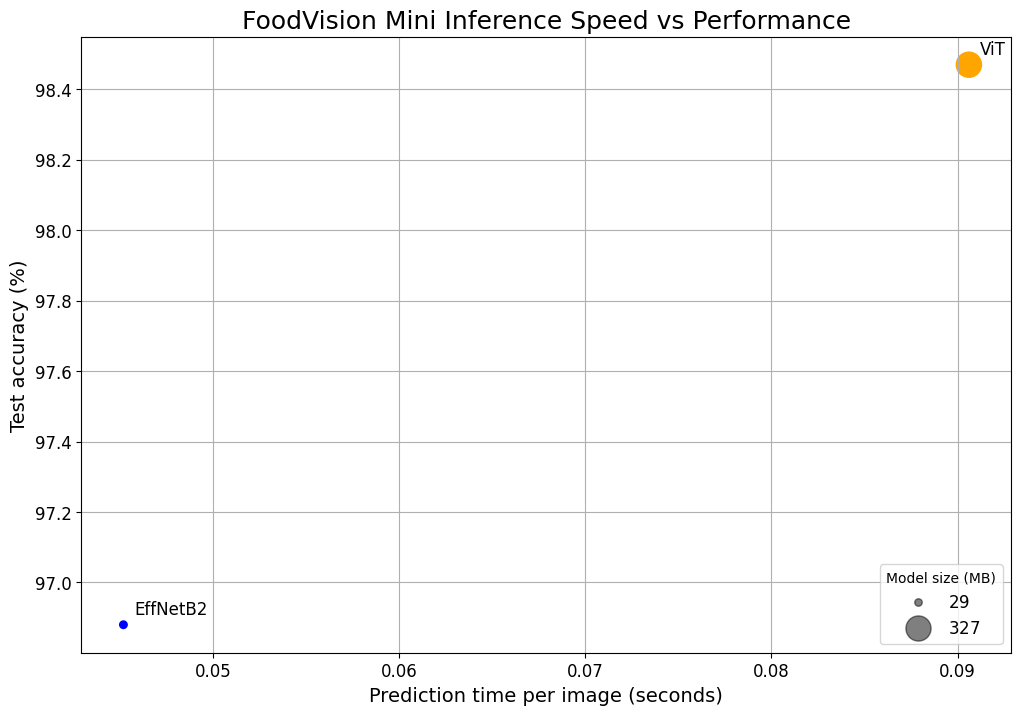

In [68]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["models"], 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("foodvision-mini-inference-speed-vs-performance.png")

# Show the figure
plt.show()

As we can see our models' performance levels (on the test loss and test accuracy) aren't too extreme.

But since we'd like to put an emphasis on speed, we're going to stick with deploying EffNetB2 since it's faster and has a much smaller footprint.

## 1.7 Bringing FoodVision Mini to life by creating a Gradio demo
We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

In [69]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Gradio version: 3.19.1


## 1.7.1 Creating a function to map our inputs and outputs

To create FoodVision Mini demo with Gradio, we'll need a function to map our inputs to our outputs.

We want to create a function that takes an image as input, preprocesses (transforms) it, makes a prediction with EffNetB2 and then returns the prediction (pred label) as well as the prediction probability (pred prob).

Let's create a function called predict() that do the following:

`images of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)`

First, we make sure our EffNetB2 model is on the CPU (since we're sticking with CPU-only predictions, however you could change this if you have access to a GPU).

In [70]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device 
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function described above.

In [71]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension on 0th index

  # Put model into eval mode, make predictions 
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the pred time
  end_time = timer()
  pred_time = round(end_time-start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

Now let's see our function in action by performing a prediction on a random image from the test dataset.

In [72]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/367422.jpg

Prediction label and probability dictionary: 
{'pizza': 0.017834043130278587, 'steak': 0.9569805264472961, 'sushi': 0.025185417383909225}
Prediction time: 0.0484 seconds


### 1.7.2 Creating a list of example images

Before we create the demo, let's create a list of examples, because Gradio's Interface class takes a list of examples as an optional parameter (gradio.Interface(examples=List[Any])).

So let's create a list of lists containing random filepaths to our test images.

In [81]:
# Create list of example inputs to our Gradio demo
example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/2274102.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/552171.jpg']

### 1.7.3 Building a Gradio Interface

Let's create a Gradio interface to replicate the workflow:

`input: image -> transform -> predict with EffNetB2 -> output: pred, prob prob, time`

In [82]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)"

# Create the Gradio demo
demo = gr.Interface(
    fn = predict, # a Python function to map inputs to outputs
    inputs = gr.Image(type='pil'), # the input to our interface such as an image using gradio.Image() 
    outputs = [gr.Label(num_top_classes=3, label ="Predictions"), # the output of our interface once the inputs have gone 
               # through the fn, such as a label using gradio.Label() (for our model's predicted labels) or 
               # number using gradio.Number() (for our model's prediction time).
               gr.Number(label ='Prediction time (s)')], 
               examples=example_list, # a list of examples to showcase for the demo.
               title=title, # a string title of the demo.
               description=description, # a string description of the demo.
               article=article) #  a reference note at the bottom of the demo.            
# Launch the demo
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Running on local URL:  http://127.0.0.1:7865
Running on public URL: https://3ae8ed2aab2019fef2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## 1.8 Turning our FoodVision Mini Gradio Demo into a deployable app

Gradio demos from Google Colab expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces: https://huggingface.co/docs/hub/spaces


### 1.8.1 Deployed Gradio app structure

To upload our demo Gradio app, we put everything relating to it into a single directory.
For example, our demo might live at the path demos/foodvision_mini/ with the file structure:

```
demos/
└── foodvision_mini/
    ├── pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Where:
* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our Gradio app.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt` contains the dependencies to run our app such as torch, torchvision and gradio.

### 1.8.2 Creating a demos folder to store our FoodVision app files



Firstly, we create a demos/directory to store all of our FoodVision Mini app files.

We can do with Python's `pathlib.Path("path_to_dir")` to establish the directory path and `pathlib.Path("path_to_dir").mkdir()` to create it.

In [84]:
import shutil
from pathlib import Path

# Create FoodVision Mini demo path
food_vision_mini_demo_path = Path("demos/foodvision_mini")

# Remove files that might exist and create a new directory
if food_vision_mini_demo_path.exists():
  shutil.rmtree(food_vision_mini_demo_path)
  food_vision_mini_demo_path.mkdir(parents = True, 
                                   exist_ok = True)
else:
  food_vision_mini_demo_path.mkdir(parents = True, 
                                   exist_ok = True)
!ls demos/foodvision_mini

### 1.8.3 Creating a folder of example images to use with our FoodVision Mini demo

Now we've a directory to store our FoodVision Mini demo files. 
Let's add some examples to it.
3 random images from test set should be enough.

In [86]:
import shutil
from pathlib import Path

# Create an examples directory
food_vision_mini_examples_path = food_vision_mini_demo_path / 'examples'
food_vision_mini_examples_path.mkdir(parents = True, 
                                     exist_ok = True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
    destination = food_vision_mini_examples_path/example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of lists from our examples/directory.

In [87]:
import os

# Get examples filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(food_vision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

### 1.8.4 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [89]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = food_vision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src = effnetb2_foodvision_mini_model_path, 
              dst = effnetb2_foodvision_mini_model_destination)
  
  print(f"[INFO] Model move complete. ")

# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")


[INFO] Attempting to move models/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos/foodvision_mini/pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth: True


### 1.8.5 Turning our EffNetB2 model into a Python script (model.py)

We have a saved .pth model state_dict and want to load it into a model instance.

Let's move our create_effnetb2_model() function to a script so we can reuse it.

In [90]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # 4. Freeze the base layers in the model, this will stop all layers from training
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed 
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, transforms

Writing demos/foodvision_mini/model.py


### 1.8.6 Turning our FoodVision Mini Gradio app into a Python script (app.py)

The app.py file will have four major parts:

1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (predict())
4. Gradio app - Gradio interface + launch command

In [91]:
%%writefile demos/foodvision_mini/app.py

### 1. Imports and class names setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names 
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = 3
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f = 'pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth',
               map_location = torch.device("cpu")) # load the model to the CPU regardless of the device it trained on (we won't necessarily have a GPU when we deploy)
)

### 3. Predict function (predict())
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension on 0th index

  # Put model into eval mode, make predictions 
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the pred time
  end_time = timer()
  pred_time = round(end_time-start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app - our Gradio interface + launch command

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(
    fn = predict, 
    inputs = gr.Image(type='pil'),
    outputs = [gr.Label(num_top_classes=3, label ="Predictions"),
               gr.Number(label ='Prediction time (s)')], 
               examples=example_list,
               title=title,
               description=description,
               article=article)               
# Launch the demo
demo.launch()


Writing demos/foodvision_mini/app.py


### 1.8.7 Creating a requirements file for FoodVision Mini (requirements.txt)

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:

* torch
* torchvision
* gradio

In [92]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 1.9  Deploying our FoodVision Mini app HuggingFace Spaces

Let's check out the demo files we've got inside demos/foodvision_mini

In [93]:
!ls demos/foodvision_mini

app.py	  pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth
examples  requirements.txt
model.py


In [94]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynd" "*__pycache__*" "*ipyndb_checkpoints*" 

  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 54%)
  adding: pretrained_effnetb2_feature_exractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [95]:
# Download zip file 
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.")

Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.


After uploading our FoodVision Mini Gradio demo to Hugging Face Spaces, we can embed this demo into notebook.

In [96]:
from IPython.display import IFrame

IFrame(src = "https://hf.space/embed/vic-art/foodvision_mini/+", width = 900, height = 750)

# 2.  Food Vision Big (using 20% of Food101 dataset)

Now we are going to make a model for classifying all Food101 classes, but using only 20% of data. 

## 2.1 Creating a model and transforms for FoodVision Big

When creating FoodVision Mini we saw that the EffNetB2 model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

We can create an EffNetB2 feature extractor for Food101 by using our create_effnetb2_model() function we created above, and passing it the parameter num_classes=101 (since Food101 has 101 classes).

In [156]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

In [157]:
from torchinfo import summary

summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

The outer layers (the classifier layers), which are trainable have an ouput shape of [batch_size, 101] (101 for 101 classes in Food101).

This time we add a data augmentation to  transforms (effnetb2_transforms) to augment the training data to artificially increase the diversity of a training dataset to hopefully prevent overfitting.


In [158]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])  
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Now will use `food101_train_transforms` for the training data and `effnetb2_transforms` for the testing/inference data.

In [159]:
print(f"Training transforms:\n{food101_train_transforms}\n") 
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


## 2.2 Getting data for FoodVision Big

To get the whole Food101 dataset, we can use torchvision.datasets.Food101().

Then we download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively.

In [160]:
from torchvision import datasets 

# Setup data directory
from pathlib import Path
data_dir = Path('data')

# Get the training data (~750 x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split = "train",
                              transform = food101_train_transforms, # apply data augmentation to the training data
                              download= True)
# Get the training data (~250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                              split = "test",
                              transform = effnetb2_transforms, # apply data augmentation to the training data
                              download= True)

In [161]:
# Get Food101 class names 
food101_class_names = train_data.classes 

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## 2.3 Creating a subset of the Food101 dataset for faster experimenting 

Let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy on the test 
dataset (see the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf).

We want to beat this result using modern deep learning techniques and only 20% of the data.

To make our FoodVision Big (20% data) split, let's create a function called `split_dataset()` to split a given dataset into certain proportions.

In [162]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets, 
                  split_size: float = 0.2,
                  seed: int = 42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size {length_1} and {length_2}")

    # Create splits with given random splits 
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                 lengths = [length_1, length_2],
                                                                 generator = torch.manual_seed(seed))
    return random_split_1, random_split_2

In [163]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset= train_data,
                                                 split_size = 0.2)

test_data_food101_20_percent, _ = split_dataset(dataset= test_data,
                                                split_size = 0.2) 

[INFO] Splitting dataset of length 75750 into splits of size 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size 5050 and 20200


In [164]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

In [165]:
len(train_data), len(test_data)

(75750, 25250)


## 2.4 Turning Food101 Datasets into `DataLoaders`

Let's turn our Food101 20% dataset splits into DataLoader's using torch.utils.data.DataLoader().

We'll set `shuffle=True` for the training data only.

In [166]:
import torch
import os

NUM_WORKERS=os.cpu_count()

BATCH_SIZE = 32

# Creating Fodd101 20% training DataLoader 
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset = train_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = True,
                                                                  num_workers = NUM_WORKERS)
# Creating Fodd101 20% testing DataLoader 
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset = test_data_food101_20_percent,
                                                                batch_size = BATCH_SIZE,
                                                                shuffle = False,
                                                                num_workers = NUM_WORKERS)

In [167]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

## 2.5 Training FoodVision Big

Things for training:
1. 5 epochs
2. optimizer: `torch.optim.Adam(lr = 1e-3)`
3. because we've got so many classes, we setup a loss function with [label_smoothing](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing) of 0.1: `torch.nn.CrossEntropyLoss(label_smoothing = 0.1)`


Why do we use label smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

In essence, rather than a model getting too confident on a single label, label smoothing gives a non-zero value to other labels to increase generalization.

Without label smoothing and 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

In [168]:
from scripts import engine

# Setup the optimizer 
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)
# Setup the loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

 20%|██        | 1/5 [00:32<02:09, 32.45s/it]

Epoch: 1 | train_loss: 3.6469 | train_acc: 0.2773 | test_loss: 2.7748 | test_acc: 0.4885


 40%|████      | 2/5 [01:04<01:37, 32.43s/it]

Epoch: 2 | train_loss: 2.8631 | train_acc: 0.4389 | test_loss: 2.4755 | test_acc: 0.5325


 60%|██████    | 3/5 [01:37<01:04, 32.47s/it]

Epoch: 3 | train_loss: 2.6597 | train_acc: 0.4829 | test_loss: 2.3629 | test_acc: 0.5592


 80%|████████  | 4/5 [02:09<00:32, 32.41s/it]

Epoch: 4 | train_loss: 2.5511 | train_acc: 0.5115 | test_loss: 2.3103 | test_acc: 0.5666


100%|██████████| 5/5 [02:42<00:00, 32.44s/it]

Epoch: 5 | train_loss: 2.4962 | train_acc: 0.5255 | test_loss: 2.2822 | test_acc: 0.5796


## 2.6 Inspecting loss curves of FoodVision Big Model

Let's visualize our FoodVision Big loss curves.

We can do so with the `plot_loss_curves()` function from `helper_functions.py`.

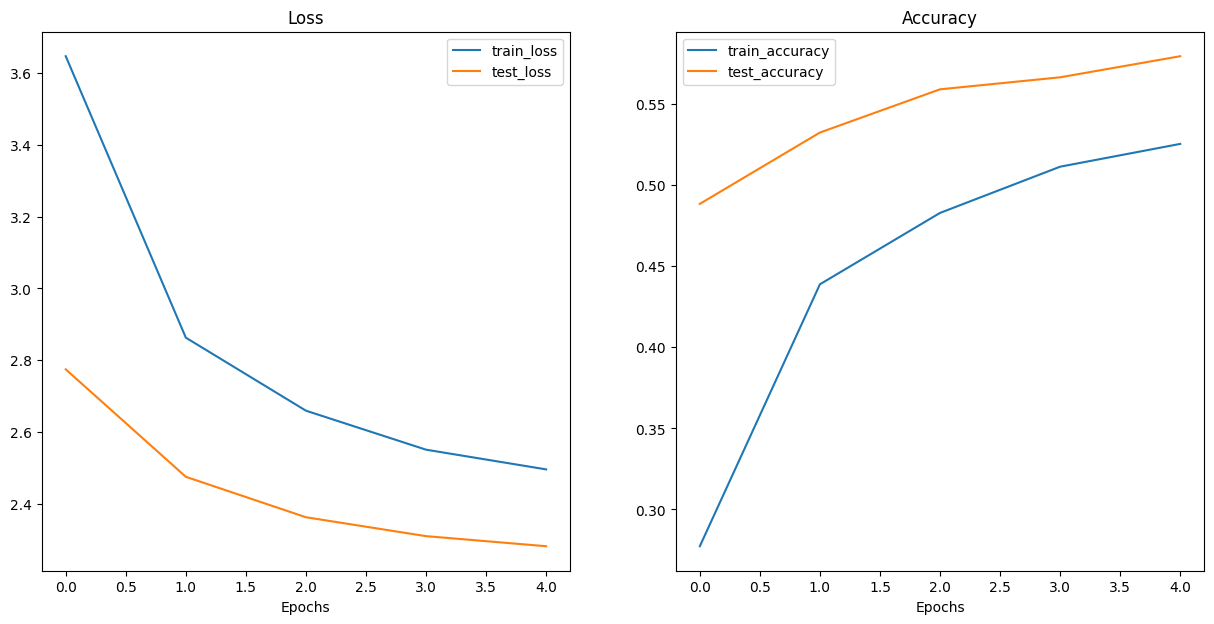

In [170]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

It looks like our regularization techniques (data augmentation and label smoothing) helped prevent our model from overfitting (the training loss is still higher than the test loss) this indicates our model has more capacity to learn and could improve with further training.

## 2.7 Save and load FoodVision Big Model

We save it so we can load it back in later.

In [171]:
from scripts import helper_functions

# Create a model path
effnetb2_food101_model_path = "pretrained_effnetb2_feature_extractor_food101_20_precent.pth"

# Save FoodVision Big Model
helper_functions.save_model(model = effnetb2_food101,
                 target_dir = 'models/',
                 model_name = effnetb2_food101_model_path)

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_food101_20_precent.pth


Let's make sure we can load the model back in.

We create a model instance with `create_effnetb2_model(num_classes=101)` and then load saved `state_dict()` with `torch.nn.Module.load_state_dict()` and `torch.load()`.

In [172]:
# Create Food101 compatible EffNetB2 instance 
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/pretrained_effnetb2_feature_extractor_food101_20_precent.pth"))

<All keys matched successfully>

## 2.8 Checking FoodVision Big model size

In [173]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


The model size stayed largely the same (30 MB for FoodVision Big and 29 MB for FoodVision Mini) despite the large increase in the number of classes.

This is because all the extra parameters for FoodVision Big are only in the last layer (the classifier head).

All of the base layers are the same between FoodVision Big and FoodVision Mini.

In [174]:
from torchinfo import summary


summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

| Model | Output shape (num classes) | Trainable parameters | Total parameters | Model size (MB) |
|----------|:---------------:|:---------------:|:---------------:|:---------------:|
| FoodVision Mini (EffNetB2 feature extractor)    | 3   | 4,227   | 7,705,221   | 29   |  
| FoodVision Big (EffNetB2 feature extractor)    | 101   | 142,309   | 7,843,303   |  30   |  


## 2.9 Turning our FoodVision Big model into a deployable app

We've got a trained and saved EffNetB2 model on 20% of the Food101 dataset.

We are going to deploy our FoodVision Big model in the same way we deployed our FoodVision Mini model, as a Gradio demo on Hugging Face Spaces.

To begin, let's create a `demos/foodvision_big/` directory to store our FoodVision Big demo files as well as a `demos/foodvision_big/examples` directory to hold an example image to test the demo with.

Let's create an outline for our FoodVision Big app:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt

```

In [175]:
from pathlib import Path

# Create FoodVision Big demo path 
foodvision_big_demo_path = Path('demos/foodvision_big/')

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents = True, 
                               exist_ok = True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path/"examples").mkdir(parents = True, exist_ok = True)

In [176]:
!ls demos/foodvision_big/

examples


### 2.9.1 Downloading an example image and moving it to the `examples` folder

In [177]:
# Download and move example image
!wget https://github.com/vic-art/Food-classification-model-and-deployment/raw/main/Hamburger-cheeseburger.jpg
!mv Hamburger-cheeseburger.jpg demos/foodvision_big/examples/Hamburger-cheeseburger.jpg

--2023-03-04 22:19:18--  https://github.com/vic-art/Food-classification-model-and-deployment/raw/main/Hamburger-cheeseburger.jpg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vic-art/Food-classification-model-and-deployment/main/Hamburger-cheeseburger.jpg [following]
--2023-03-04 22:19:18--  https://raw.githubusercontent.com/vic-art/Food-classification-model-and-deployment/main/Hamburger-cheeseburger.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131776 (129K) [image/jpeg]
Saving to: ‘Hamburger-cheeseburger.jpg’

Hamburger-cheesebur 100%[===================>] 128.69K  --.-KB/s    in 0.02s

We move our trained Food101 EffNetB2 model from `models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth` to `demos/foodvision_big` as well.

In [181]:
!mv models/pretrained_effnetb2_feature_extractor_food101_20_precent.pth demos/foodvision_big/

### 2.9.2 Saving Food101 class names to file (`class_names.txt`)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our app.py file, we save them to a .txt file and read them in when necessary instead.

In [182]:
# Check out the first 10 Food101 class names 
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [184]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path/ "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [185]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, 'w') as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [186]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, 'r') as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 2.9.3 Turning FoodVision Big Model into a Python script ('model.py')

Let's create a script that's capable of instantiating an EffNetB2 feature extractor model along with its necessary transforms.

In [187]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # 4. Freeze the base layers in the model, this will stop all layers from training
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed 
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, transforms

Writing demos/foodvision_big/model.py


### 2.9.4 Turning FoodVision Big Gradio app into a Python script (`app`)

The app.py file will have four major parts:

1. Imports and class names setup - for class names, we'll need to import from class_names.txt rather than with a Python list
2. Model and transforms preparation - The model will have num_classes=101 rather than num_classes=3. We'll also be sure to load the weights from "pretrained_effnetb2_feature_extractor_food101_20_percent.pth".
3. Predict function (predict()) - this can stay the same as the original predict()
4. Gradio app - our Gradio interface + launch command - The Gradio interace will have different title, description and article parameters to reflect the details of FoodVision Big.

In [188]:
%%writefile demos/foodvision_big/app.py
### Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names 
with open('class_names.txt', 'r') as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transform preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

# Load saved weights 
effnetb2.load_state_dict(
    torch.load(f='pretrained_effnetb2_feature_extractor_food101_20_precent.pth',
               map_location =torch.device("cpu")) #load to CPU
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension on 0th index

  # Put model into eval mode, make predictions 
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the pred time
  end_time = timer()
  pred_time = round(end_time-start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app - our Gradio interface + launch command

# Create title, description and article
title = "FoodVision Big 🍕👁"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images of [101 classes of food from Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]


# Create the Gradio demo
demo = gr.Interface(
    fn = predict, 
    inputs = gr.Image(type='pil'),
    outputs = [gr.Label(num_top_classes=5, label ="Predictions"),
               gr.Number(label ='Prediction time (s)')], 
               examples=example_list,
               title=title,
               description=description,
               article=article)               
# Launch the demo!
demo.launch()

Writing demos/foodvision_big/app.py


### 2.9.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [189]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


### 2.9.6 Downloading our FoodVision Big app files

In [190]:
# Change into the foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 53%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/Hamburger-cheeseburger.jpg (deflated 0%)
  adding: model.py (deflated 54%)
  adding: pretrained_effnetb2_feature_extractor_food101_20_precent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [191]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually.")

Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually.


# 3. Creating FoodVision Big (using entire Food101 dataset)

Now we are going to make a model for classifying all Food101 classes using entire Food101 dataset. 

## 3.1 Creating a model and transforms for FoodVision Big

This time we also choose EffNetB2 model, since it gives a good tradeoff between speed and performance (it performed well with a fast speed).

We create an instance of the EffNetB2 model for Food101 by using `create_effnetb2_model()` function we created above, and passing it `num_classes=101` (since Food101 has 101 classes).

In [29]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101_full, effnetb2_transforms_full = create_effnetb2_model(num_classes = 101)

We add a data augmentation to transforms (effnetb2_transforms) to augment the training data to artificially increase the diversity of a training dataset to hopefully prevent overfitting.

In [30]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms_full = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms_full,
])

We will use `food101_train_transforms` for the training data and `effnetb2_transforms` for the testing/inference data.

## 3.2 Getting data

To get the whole Food101 dataset, we can use `torchvision.datasets.Food101()`.

Then we download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively.

In [31]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms_full, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms_full, # perform normal EffNetB2 transforms on test data
                             download=True)

In [32]:
len(train_data), len(test_data)

(75750, 25250)

In [33]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## 3.3 Turning our Food101 datasets into DataLoaders

We turn Food101 dataset splits into DataLoader's using `torch.utils.data.DataLoader()` by setting `shuffle=True` for the training data only.

In [34]:
import torch
import os

NUM_WORKERS=os.cpu_count()

BATCH_SIZE = 32

# Creating Fodd101 training DataLoader 
train_dataloader_food101 = torch.utils.data.DataLoader(dataset = train_data,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = True,
                                                                  num_workers = NUM_WORKERS)
# Creating Fodd101 testing DataLoader 
test_dataloader_food101 = torch.utils.data.DataLoader(dataset = test_data,
                                                                batch_size = BATCH_SIZE,
                                                                shuffle = False,
                                                                num_workers = NUM_WORKERS)

In [20]:
len(train_dataloader_food101), len(test_dataloader_food101)

(2368, 790)

## 3.4 Training FoodVision Big model

Things for training:
1. 10 epochs
2. optimizer: `torch.optim.Adam(lr = 1e-3)`
3. because we've got so many classes, we setup a loss function with [label_smoothing](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing) of 0.1: `torch.nn.CrossEntropyLoss(label_smoothing = 0.1)`. Label smoothing helps to prevent overfitting.
4. [scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html) - Reduce learning rate when a metric (in our case, accuracy) has stopped improving. 

In [35]:
from scripts import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101_full.parameters(),
                             lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.1, 
                                                       patience=2,
                                                       threshold=0.0001,
                                                       min_lr=1e-5,
                                                       verbose=True)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes


set_seeds()    
effnetb2_food101_full_results = engine.train(model=effnetb2_food101_full,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader=test_dataloader_food101,
                                        optimizer=optimizer,
                                        scheduler=scheduler,
                                        loss_fn=loss_fn,
                                        epochs=25,
                                        device=device,
                                        save_best_model=True,
                                        target_dir="models/", 
                                        model_name="effnetb2_food101_model_pretrained_best.pth")


  4%|▍         | 1/25 [02:33<1:01:28, 153.70s/it]

Epoch: 1 | train_loss: 2.9822 | train_acc: 0.4063 | test_loss: 2.1778 | test_acc: 0.6107
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


  8%|▊         | 2/25 [05:07<58:57, 153.82s/it]  

Epoch: 2 | train_loss: 2.6470 | train_acc: 0.4808 | test_loss: 2.1142 | test_acc: 0.6256
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 12%|█▏        | 3/25 [07:41<56:21, 153.71s/it]

Epoch: 3 | train_loss: 2.6216 | train_acc: 0.4891 | test_loss: 2.0714 | test_acc: 0.6391
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 16%|█▌        | 4/25 [10:14<53:47, 153.69s/it]

Epoch: 4 | train_loss: 2.5933 | train_acc: 0.4983 | test_loss: 2.0553 | test_acc: 0.6433
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 20%|██        | 5/25 [12:48<51:12, 153.64s/it]

Epoch: 5 | train_loss: 2.5931 | train_acc: 0.4988 | test_loss: 2.0547 | test_acc: 0.6477
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 24%|██▍       | 6/25 [15:22<48:41, 153.75s/it]

Epoch: 6 | train_loss: 2.5934 | train_acc: 0.4983 | test_loss: 2.0340 | test_acc: 0.6498
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 28%|██▊       | 7/25 [17:55<46:05, 153.65s/it]

Epoch: 7 | train_loss: 2.5918 | train_acc: 0.4995 | test_loss: 2.0422 | test_acc: 0.6461
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 32%|███▏      | 8/25 [20:29<43:34, 153.77s/it]

Epoch: 8 | train_loss: 2.5852 | train_acc: 0.4996 | test_loss: 2.0494 | test_acc: 0.6449
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 36%|███▌      | 9/25 [23:03<41:00, 153.77s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 9 | train_loss: 2.5891 | train_acc: 0.5007 | test_loss: 2.0455 | test_acc: 0.6464
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 40%|████      | 10/25 [25:37<38:26, 153.74s/it]

Epoch: 10 | train_loss: 2.5055 | train_acc: 0.5209 | test_loss: 2.0180 | test_acc: 0.6563
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 44%|████▍     | 11/25 [28:11<35:53, 153.82s/it]

Epoch: 11 | train_loss: 2.4955 | train_acc: 0.5249 | test_loss: 2.0060 | test_acc: 0.6590
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 48%|████▊     | 12/25 [30:44<33:18, 153.74s/it]

Epoch: 12 | train_loss: 2.4894 | train_acc: 0.5267 | test_loss: 2.0044 | test_acc: 0.6602
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 52%|█████▏    | 13/25 [33:19<30:46, 153.89s/it]

Epoch: 13 | train_loss: 2.4802 | train_acc: 0.5293 | test_loss: 1.9892 | test_acc: 0.6653
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 56%|█████▌    | 14/25 [35:52<28:12, 153.86s/it]

Epoch: 14 | train_loss: 2.4779 | train_acc: 0.5278 | test_loss: 1.9966 | test_acc: 0.6628
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 60%|██████    | 15/25 [38:26<25:38, 153.81s/it]

Epoch: 15 | train_loss: 2.4748 | train_acc: 0.5299 | test_loss: 1.9818 | test_acc: 0.6665
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 64%|██████▍   | 16/25 [41:00<23:04, 153.82s/it]

Epoch: 16 | train_loss: 2.4688 | train_acc: 0.5308 | test_loss: 1.9816 | test_acc: 0.6669
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 68%|██████▊   | 17/25 [43:34<20:30, 153.87s/it]

Epoch: 17 | train_loss: 2.4688 | train_acc: 0.5311 | test_loss: 1.9749 | test_acc: 0.6693
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 72%|███████▏  | 18/25 [46:08<17:57, 153.93s/it]

Epoch: 18 | train_loss: 2.4648 | train_acc: 0.5320 | test_loss: 1.9878 | test_acc: 0.6669
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 76%|███████▌  | 19/25 [48:42<15:24, 154.02s/it]

Epoch: 19 | train_loss: 2.4630 | train_acc: 0.5342 | test_loss: 1.9925 | test_acc: 0.6657
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 80%|████████  | 20/25 [51:16<12:49, 153.98s/it]

Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 20 | train_loss: 2.4520 | train_acc: 0.5346 | test_loss: 1.9923 | test_acc: 0.6652
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 84%|████████▍ | 21/25 [53:50<10:16, 154.04s/it]

Epoch: 21 | train_loss: 2.4464 | train_acc: 0.5347 | test_loss: 1.9942 | test_acc: 0.6649
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 88%|████████▊ | 22/25 [56:24<07:42, 154.03s/it]

Epoch: 22 | train_loss: 2.4423 | train_acc: 0.5381 | test_loss: 1.9777 | test_acc: 0.6690
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 92%|█████████▏| 23/25 [58:58<05:08, 154.04s/it]

Epoch: 23 | train_loss: 2.4471 | train_acc: 0.5379 | test_loss: 1.9736 | test_acc: 0.6707
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


 96%|█████████▌| 24/25 [1:01:32<02:34, 154.02s/it]

Epoch: 24 | train_loss: 2.4416 | train_acc: 0.5385 | test_loss: 1.9741 | test_acc: 0.6706
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


100%|██████████| 25/25 [1:04:06<00:00, 153.87s/it]

Epoch: 25 | train_loss: 2.4489 | train_acc: 0.5333 | test_loss: 1.9738 | test_acc: 0.6701
[INFO] Saving model to: models/effnetb2_food101_model_pretrained_best.pth


## 3.5 Inspecting loss curves 

We visualise the results with the `plot_loss_curves()` function from `helper_functions.py`.

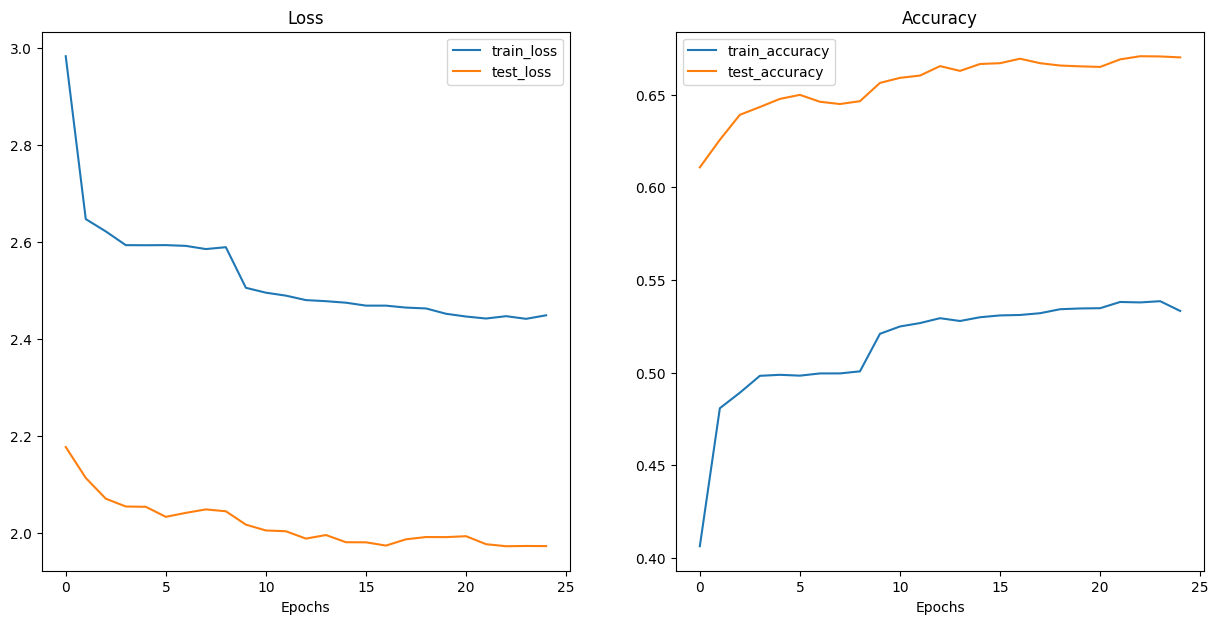

In [39]:
from scripts.helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_full_results)

Longer training, use of more data (the entire Food101 dataset) and scheduler lead to better results in terms of test loss and accuracy. The previous model that was trained on 20% of Food101 dataset has the following results: test_accuracy - 57.96%, test_loss - 2.28. 

## 3.6 Checking the model size

In [42]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_full_dataset_model_size = Path("models/effnetb2_food101_model_pretrained_best.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_full_dataset_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 3.7 Turning our Foodvision Big model into a deployable app

We've got a trained and saved EffNetB2 model on entire Food101 dataset.

We are going to deploy our model as a Gradio demo on Hugging Face Spaces.

To begin, let's create a `demos/foodvision_big_100_percent/` directory to store our FoodVision Big demo files as well as a `demos/foodvision_big_100_percent/examples` directory to hold an example image to test the demo with.

Let's create an outline for our FoodVision Big app:
```
demos/
  foodvision_big_100_percent/
    effnetb2_food101_model_pretrained_best.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [43]:
from pathlib import Path

# Create FoodVision Big demo path 
foodvision_big_100_percent_demo_path = Path('demos/foodvision_big_100_percent')

# Make FoodVision Big demo directory
foodvision_big_100_percent_demo_path.mkdir(parents = True, 
                               exist_ok = True)

# Make FoodVision Big demo examples directory
(foodvision_big_100_percent_demo_path/"examples").mkdir(parents = True, exist_ok = True)

 ### 3.7.1 Adding images to the example folder to use with our FoodVision Big demo¶

Now we've got a directory to store our FoodVision Big demo files, let's add some examples to it from test dataset.

In [94]:
import shutil
from pathlib import Path

# 1. Collect 5 random test dataset image paths
foodvision_mini_examples = [Path('data/food-101/images/cheesecake/1271183.jpg'),
                            Path('data/food-101/images/grilled_salmon/1101252.jpg'),
                            Path('data/food-101/images/greek_salad/1203701.jpg'),
                            Path('data/food-101/images/paella/11419.jpg'),
                            Path('data/food-101/images/tacos/1026681.jpg')
                           ]

# 2. Copy these images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_big_100_percent_demo_path/"examples"/ example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/food-101/images/cheesecake/1271183.jpg to demos/foodvision_big_100_percent/examples/1271183.jpg
[INFO] Copying data/food-101/images/grilled_salmon/1101252.jpg to demos/foodvision_big_100_percent/examples/1101252.jpg
[INFO] Copying data/food-101/images/greek_salad/1203701.jpg to demos/foodvision_big_100_percent/examples/1203701.jpg
[INFO] Copying data/food-101/images/paella/11419.jpg to demos/foodvision_big_100_percent/examples/11419.jpg
[INFO] Copying data/food-101/images/tacos/1026681.jpg to demos/foodvision_big_100_percent/examples/1026681.jpg


Now to verify our examples are present, let's list the contents of our `demos/foodvision_big_100_present/examples/` directory with `os.listdir()` and then format the filepaths into a list of lists (so it's compatible with Gradio's `gradio.Interface()` example parameter).

In [95]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_big_100_percent_demo_path/"examples")]
example_list

[['examples/11419.jpg'],
 ['examples/1026681.jpg'],
 ['examples/1271183.jpg'],
 ['examples/1101252.jpg'],
 ['examples/1203701.jpg']]

### 3.7.2 Saving Food101 class names to file (class_names.txt)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our app.py file, we save them to a .txt file and read them in when necessary instead.

In [97]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [98]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_100_percent_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big_100_percent/class_names.txt


In [99]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 3.7.3 Moving our trained EffNetB2 model to our FoodVision Big demo directory

We previously saved our FoodVision Mini EffNetB2 feature extractor model under `models/effnetb2_food101_model_pretrained_best.pth`. Let's move our model to `demos/foodvision_mini directory`.

In [103]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_big_model_path = "models/effnetb2_food101_model_pretrained_best.pth"

# Create a destination path for our target model 
effnetb2_foodvision_big_model_destination = foodvision_big_100_percent_demo_path / effnetb2_foodvision_big_model_path.split("/")[1]


# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_big_model_path} to {effnetb2_foodvision_big_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_big_model_path, 
                dst=effnetb2_foodvision_big_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_big_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_big_model_destination}: {effnetb2_foodvision_big_model_destination.exists()}")

[INFO] Attempting to move models/effnetb2_food101_model_pretrained_best.pth to demos/foodvision_big_100_percent/effnetb2_food101_model_pretrained_best.pth
[INFO] Model move complete.


### 3.7.4 Turning our EffNetB2 model into a Python script (model.py)

Our current model's state_dict is saved to `demos/foodvision_big_100_percent/effnetb2_food101_model_pretrained_best.pth`.

To load it in we can use `model.load_state_dict()` along with `torch.load()`.

But before we can do this, we first need a way to instantiate a model.

To do this in a modular fashion we'll create a script called `model.py` which contains our `create_effnetb2_model()` function we created in section 3.1.

That way we can import the function in another script (app.py) and then use it to create our EffNetB2 model instance as well as get its appropriate transforms.

In [105]:
%%writefile demos/foodvision_big_100_percent/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_big_100_percent/model.py


### 3.7.5 Turning FoodVision Big Gradio app into a Python script (`app`)

The app.py file will have four major parts:

1. Imports and class names setup - for class names, we'll need to import from class_names.txt rather than with a Python list
2. Model and transforms preparation - The model will have num_classes=101 rather than num_classes=3. We'll also be sure to load the weights from "pretrained_effnetb2_feature_extractor_food101_20_percent.pth".
3. Predict function (predict()) - this can stay the same as the original predict()
4. Gradio app - our Gradio interface + launch command - The Gradio interace will have different title, description and article parameters to reflect the details of FoodVision Big.

In [107]:
%%writefile demos/foodvision_big_100_percent/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="effnetb2_food101_model_pretrained_best.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big  🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big_100_percent/app.py


### 3.7.6 Creating a requirements file for FoodVision Big (requirements.txt)

Now all we need is a requirements.txt file to tell our Hugging Face Space what dependencies our FoodVision Big app requires.

In [108]:
%%writefile demos/foodvision_big_100_percent/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big_100_percent/requirements.txt


### 3.7.7 Downloading our FoodVision Big app files

We've got all the files we need to deploy our FoodVision Big app on Hugging Face, let's now zip them together and download them.

In [110]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big_100_percent && zip -r ../foodvision_big_100_percent.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_food101_model_pretrained_best.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/11419.jpg (deflated 23%)
  adding: examples/1026681.jpg (deflated 0%)
  adding: examples/1271183.jpg (deflated 1%)
  adding: examples/1101252.jpg (deflated 0%)
  adding: examples/1203701.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


In [111]:
# IPython is a library to help work with Python iteractively 
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://hf.space/embed/vic-art/foodvision_big/+", width=900, height=750)